In [1]:
import os 
os.chdir("..")

In [2]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import json
from utils.visualization import plot_molecules, plot_molecule
from utils.preprocessing import get_average_trajectory_positions, get_time_distance_matrix
import processor.data as data_processor
import processor.graph as graph_processor
import utils.metrics as metrics
from utils.export import *

In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU.")

GPU not available. Using CPU.


# Load data

In [52]:
integrin = "a5b1"    # "a5b1", "aVb3", "alpha2bbeta3", "alphaVbeta3"
data_type = "clamp"  # "clamp", "ramp" 
u, extensions, config = data_processor.load_data(data_type, integrin)

In [53]:
# visualize 
t = 0
rep = 0

# set to first frame
u[rep][extensions[t]].trajectory[0] 

plot_molecules([u[rep][extensions[t]].select_atoms(f"protein and name CA").positions])

# Define domains

In [54]:
# define domains 
ext = extensions[0]

if integrin == "aVb3":
    domain_to_residues = {
        "beta-propeller": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 1-438").atoms.resindices,
        "thigh": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 439-592").atoms.resindices,
        "loopA": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 593-601").atoms.resindices,
        "calf1": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 602-738").atoms.resindices,
        "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 739-967").atoms.resindices,
        "transmembrane-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 968-984").atoms.resindices,
        "cytoplasmic-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 985-1016").atoms.resindices,
        "psi": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1-56").atoms.resindices,
        "hybrid": u[0][ext].select_atoms(f"protein and name CA and segid B and (resid 57-108 or resid 353-433)").atoms.resindices,
        "betaI": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 109-352").atoms.resindices,
        "loopB": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 434-436").atoms.resindices,
        "egf1": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 437-472").atoms.resindices,
        "egf2": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 473-522").atoms.resindices,
        "egf3": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 523-559").atoms.resindices,
        "egf4": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 560-600").atoms.resindices,
        "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 601-695").atoms.resindices,
        "transmembrane-beta": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 696-725").atoms.resindices,
        "cytoplasmic-beta": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 726-763").atoms.resindices,
    }
    
elif integrin == "alphaVbeta3":
    domain_to_residues = {
        "beta-propeller": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 1-438").atoms.resindices,
        "thigh": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 439-592").atoms.resindices,
        "loopA": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 593-601").atoms.resindices,
        "calf1": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 602-738").atoms.resindices,
        "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 739-956").atoms.resindices,
        "transmembrane-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 957-984").atoms.resindices,
        # "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 739-967").atoms.resindices,
        # "transmembrane-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 968-984").atoms.resindices,
        "cytoplasmic-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 985-1016").atoms.resindices,
        "psi": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1-56").atoms.resindices,
        "hybrid": u[0][ext].select_atoms(f"protein and name CA and segid B and (resid 57-108 or resid 353-433)").atoms.resindices,
        "betaI": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 109-352").atoms.resindices,
        "loopB": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 434-436").atoms.resindices,
        "egf1": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 437-472").atoms.resindices,
        "egf2": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 473-522").atoms.resindices,
        "egf3": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 523-559").atoms.resindices,
        "egf4": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 560-600").atoms.resindices,
        "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 601-692").atoms.resindices,
        "transmembrane-beta": u[0][ext].select_atoms(f"name CA and segid B and resid 693-725").atoms.resindices,
        # "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 601-695").atoms.resindices,
        # "transmembrane-beta": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 696-725").atoms.resindices,
        "cytoplasmic-beta": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 726-763").atoms.resindices,
    }
    
elif integrin == "a5b1":
    domain_to_residues = {
        "beta-propeller": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 1-449").atoms.resindices,
        "thigh": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 450-602").atoms.resindices,
        "loopA": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 603-611").atoms.resindices,
        "calf1": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 612-748").atoms.resindices,
        "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 749-947").atoms.resindices,
        "betaI": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 121-360").atoms.resindices,
        "hybrid": u[0][ext].select_atoms(f"protein and name CA and segid B and (resid 65-120 or resid 361-441)").atoms.resindices,
        "psi": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1-64").atoms.resindices,
        "loopB": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 442-444").atoms.resindices,
        "egf1": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 445-480").atoms.resindices,
        "egf2": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 481-533").atoms.resindices,
        "egf3": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 534-570").atoms.resindices,
        "egf4": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 571-610").atoms.resindices,
        "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 611-703").atoms.resindices
    }
    
elif integrin == "alpha2bbeta3":
    # https://www.cell.com/molecular-cell/fulltext/S1097-2765(08)00839-3?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS1097276508008393%3Fshowall%3Dtrue 
    # Zhu, Jianghai, et al. "Structure of a complete integrin ectodomain in a physiologic resting state and activation and deactivation by applied forces." Molecular cell 32.6 (2008): 849-861.
    domain_to_residues = {
        "beta-propeller": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 1-451").atoms.resindices,
        "thigh": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 452-601").atoms.resindices,
        "calf1": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 602-743").atoms.resindices,
        "calf2": u[0][ext].select_atoms(f"protein and name CA and segid A and resid 744-965").atoms.resindices,
        "transmembrane-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 966-1080").atoms.resindices,
        "cytoplasmic-alpha": u[0][ext].select_atoms(f"name CA and segid A and resid 989-1080").atoms.resindices,
        "psi": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1008-1063").atoms.resindices,
        "hybrid": u[0][ext].select_atoms(f"protein and name CA and segid B and (resid 1064-1115 or resid 1360-1440)").atoms.resindices,
        "betaI": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1116-1359").atoms.resindices,
        "egf1": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1444-1479").atoms.resindices,
        "egf2": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1480-1529").atoms.resindices,
        "egf3": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1530-1566").atoms.resindices,
        "egf4": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1567-1607").atoms.resindices,
        "betaTD": u[0][ext].select_atoms(f"protein and name CA and segid B and resid 1608-1699").atoms.resindices,
        "transmembrane-beta": u[0][ext].select_atoms(f"name CA and segid B and resid 1700-1732").atoms.resindices,
        "cytoplasmic-beta": u[0][ext].select_atoms(f"name CA and segid B and resid 1733-1770").atoms.resindices,
    }
else:
    domain_to_residues = {
        "molecule": u[0][ext].select_atoms(f"protein and name CA").atoms.resindices,
    }
    
residue_to_domain = {}
for domain, residues in domain_to_residues.items():
    for residue in residues:
        residue_to_domain[residue] = domain

domain_to_chain = {
    'beta-propeller': "A", 
    'thigh': "A", 
    'loopA': "A", 
    'calf1': "A", 
    'calf2': "A", 
    'transmembrane-alpha': "A", 
    'cytoplasmic-alpha': "A", 
    'psi': "B", 
    'hybrid': "B",
    'betaI': "B", 
    'loopB': "B", 
    'egf1': "B", 
    'egf2': "B", 
    'egf3': "B", 
    'egf4': "B", 
    'betaTD': "B", 
    'transmembrane-beta': "B", 
    'cytoplasmic-beta': "B"
}


# Construct graph

In [55]:
# construct molecular graph sequence 
graph_sequences, dygraph_sequences, resindices_to_index, dist_matrices = graph_processor.contruct_graph_dygraph(
    u=u,
    extensions=extensions,
    config=config,
    residue_to_domain=residue_to_domain,
    warm_up_frames=1,
    node_attributes="coords",
    bound_thd = 5, 
    pval_thd = 1e-5
)

ext: 12nm
There are 1595 residues and 201 timestamps


100%|██████████| 200/200 [00:00<00:00, 1364.65it/s]

There are 1595 residues and 201 timestamps


ext: 14nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1744.90it/s]

There are 1595 residues and 101 timestamps


ext: 16nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1698.31it/s]

There are 1595 residues and 101 timestamps


ext: 18nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1669.71it/s]

There are 1595 residues and 101 timestamps


start: 0
end: 3
nb_nodes:  1595
nb_interactions:  8535
ext: 12nm
There are 1595 residues and 201 timestamps


100%|██████████| 200/200 [00:00<00:00, 1739.57it/s]

There are 1595 residues and 201 timestamps


ext: 14nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1720.88it/s]

There are 1595 residues and 101 timestamps


ext: 16nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1727.89it/s]

There are 1595 residues and 101 timestamps


ext: 18nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1695.23it/s]

There are 1595 residues and 101 timestamps


start: 0
end: 3
nb_nodes:  1595
nb_interactions:  8493
ext: 12nm
There are 1595 residues and 201 timestamps


100%|██████████| 200/200 [00:00<00:00, 1754.91it/s]

There are 1595 residues and 201 timestamps


ext: 14nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1742.10it/s]

There are 1595 residues and 101 timestamps


ext: 16nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1710.05it/s]

There are 1595 residues and 101 timestamps


ext: 18nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1674.34it/s]

There are 1595 residues and 101 timestamps


start: 0
end: 3
nb_nodes:  1595
nb_interactions:  8445
ext: 12nm
There are 1595 residues and 201 timestamps


100%|██████████| 200/200 [00:00<00:00, 1525.55it/s]

There are 1595 residues and 201 timestamps


ext: 14nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1730.71it/s]

There are 1595 residues and 101 timestamps


ext: 16nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1706.66it/s]

There are 1595 residues and 101 timestamps


ext: 18nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1727.23it/s]

There are 1595 residues and 101 timestamps


start: 0
end: 3
nb_nodes:  1595
nb_interactions:  8481
ext: 12nm
There are 1595 residues and 201 timestamps


100%|██████████| 200/200 [00:00<00:00, 1720.02it/s]

There are 1595 residues and 201 timestamps


ext: 14nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1743.49it/s]

There are 1595 residues and 101 timestamps


ext: 16nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1726.88it/s]

There are 1595 residues and 101 timestamps


ext: 18nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1713.85it/s]

There are 1595 residues and 101 timestamps


start: 0
end: 3
nb_nodes:  1595
nb_interactions:  8482
ext: 12nm
There are 1595 residues and 201 timestamps


100%|██████████| 200/200 [00:00<00:00, 1736.70it/s]

There are 1595 residues and 201 timestamps


ext: 14nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1703.61it/s]

There are 1595 residues and 101 timestamps


ext: 16nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1727.74it/s]

There are 1595 residues and 101 timestamps


ext: 18nm
There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1690.36it/s]

There are 1595 residues and 101 timestamps


start: 0
end: 3
nb_nodes:  1595
nb_interactions:  8530


Number of nodes: 1595


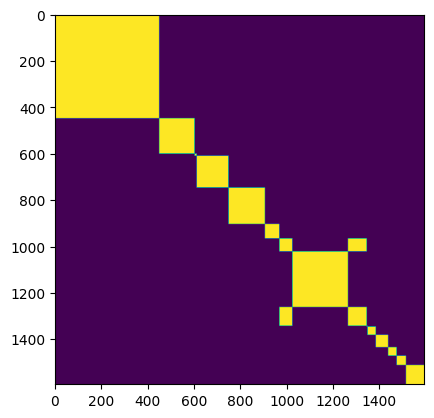

In [56]:
# build domain comembership matrix 
comembership = graph_processor.build_comembership_matrix(domain_to_residues, resindices_to_index)

plt.imshow(comembership, cmap='viridis')
plt.show()

# DynMoco

In [57]:
from training.train_dynmoco import train
from torch.utils.data import DataLoader
from utils.graph_dataset import DynamicGraphDataset, collate_sparse_graph
model_type = "dynmoco"

In [58]:
# Create the dataset
dataset = DynamicGraphDataset(graph_sequences, comembership)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_sparse_graph)

# Access a single sequence
# sample = dataset[0]  # Get the first sequence (which contains multiple replications)


Data shape: torch.Size([1595, 3]), adjacency shape: (1595, 1595)
Data shape: torch.Size([1595, 3]), adjacency shape: (1595, 1595)
Data shape: torch.Size([1595, 3]), adjacency shape: (1595, 1595)
Data shape: torch.Size([1595, 3]), adjacency shape: (1595, 1595)
Data shape: torch.Size([1595, 3]), adjacency shape: (1595, 1595)
Data shape: torch.Size([1595, 3]), adjacency shape: (1595, 1595)


In [85]:
### training params

# a5b1 clamp
if integrin == "a5b1" and data_type == "clamp":
    connectivity_regularization = 0.0 # [2.0, 5.0]
    knowledge_regularization = 20.0 # [5, 10, 20]
    sparsity_regularization = 0.002 # 0.0005
    n_epochs = 1000
    n_clusters = 35 
    learning_rate = 0.001

# aVb3 clamp
if integrin == "aVb3" and data_type == "clamp":
    connectivity_regularization = 2.0 # [2.0, 5.0] # change bck to 0.0
    knowledge_regularization = 20.0 # [5, 10, 20]
    sparsity_regularization = 0.00015 # 0.0005 change back to 0.0001
    n_epochs = 2000
    n_clusters = 50
    learning_rate = 0.0015 # changing lr to 0.01 will lead to spectral loss < -10 if trained for 3000 epochs 

# aVb3 ramp 
if integrin == "alphaVbeta3" and data_type == "ramp":
    connectivity_regularization = 5.0 # [2.0, 5.0]
    knowledge_regularization = 20.0 # [5, 10, 20]
    sparsity_regularization = 0.00015 # 0.0005
    n_epochs = 2000
    n_clusters = 50
    learning_rate = 0.001 # changing lr to 0.01 will lead to spectral loss < -10 if trained for 3000 epochs 

# aIIb3 ramp  
if integrin == "alpha2bbeta3" and data_type == "ramp":
    connectivity_regularization = 2.0 # [2.0, 5.0] # change bck to 0.0
    knowledge_regularization = 20.0 # [5, 10, 20]
    sparsity_regularization = 0.00015 # 0.0005
    n_epochs = 2000
    n_clusters = 50
    learning_rate = 0.001 # changing lr to 0.01 will lead to spectral loss < -10 if trained for 3000 epochs 

architecture = [dataset.feature_shape] + [32]
collapse_regularization = 0.2 # [0.2, 0.5]
activation = "gumbelhard" # gumbelhard, gumbelsoft, softmax
gumbel_tau = 0.5
dropout_rate = 0.0
initialization = "louvain" # must use louvain or won't converge to good results 

Total parameters: 8624, Trainable parameters: 8624


/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



Epoch 0, Spectral Loss: -4.8670, Knowledge Loss: 101.1730, Sparsity Loss: 44.8031, Total Loss: 142.6538
Epoch 100, Spectral Loss: -1.1288, Knowledge Loss: 0.1504, Sparsity Loss: 3.8125, Total Loss: 2.7303
Epoch 200, Spectral Loss: -1.4332, Knowledge Loss: 0.1727, Sparsity Loss: 1.9339, Total Loss: 0.6935
Epoch 300, Spectral Loss: -1.5248, Knowledge Loss: 0.1839, Sparsity Loss: 1.3993, Total Loss: 0.1111
Epoch 400, Spectral Loss: -1.5548, Knowledge Loss: 0.1876, Sparsity Loss: 1.2334, Total Loss: -0.0668
Epoch 500, Spectral Loss: -1.5797, Knowledge Loss: 0.1904, Sparsity Loss: 1.1122, Total Loss: -0.2007
Epoch 600, Spectral Loss: -1.6121, Knowledge Loss: 0.1932, Sparsity Loss: 0.9748, Total Loss: -0.3560
Epoch 700, Spectral Loss: -1.6547, Knowledge Loss: 0.1965, Sparsity Loss: 0.8123, Total Loss: -0.5417
Epoch 800, Spectral Loss: -1.6939, Knowledge Loss: 0.1996, Sparsity Loss: 0.6649, Total Loss: -0.7115
Epoch 900, Spectral Loss: -1.7103, Knowledge Loss: 0.2011, Sparsity Loss: 0.5981, T

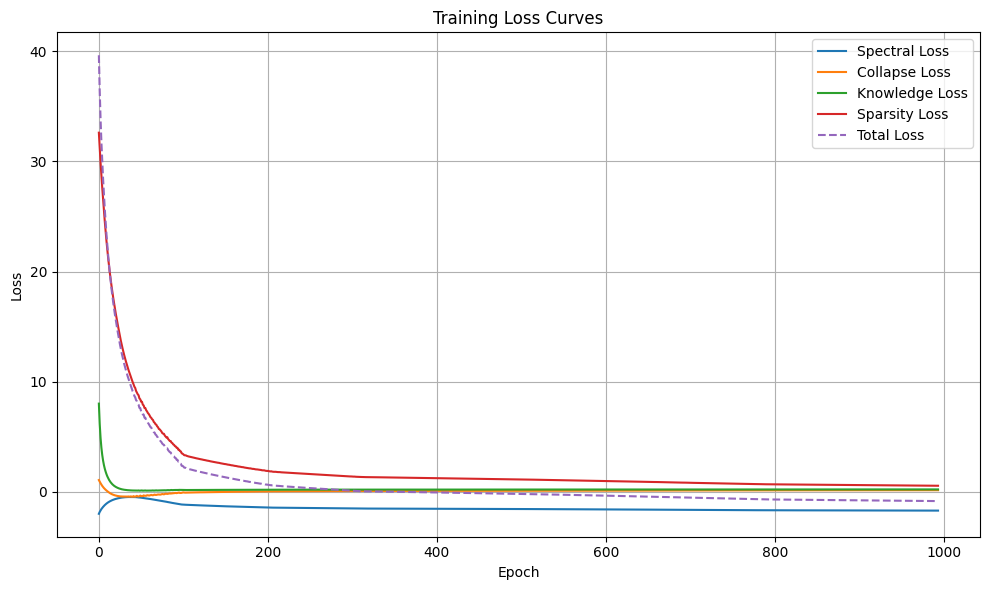

t=0: Modularity=0.905+-0.003, Conductance=0.0508+-0.003
t=1: Modularity=0.902+-0.002, Conductance=0.0542+-0.002
t=2: Modularity=0.901+-0.003, Conductance=0.0550+-0.003
t=3: Modularity=0.899+-0.003, Conductance=0.0564+-0.003


In [86]:
communities_list, model = train(dataloader, list(resindices_to_index.keys()), 
            comembership = comembership, architecture = architecture, 
            collapse_regularization = collapse_regularization, 
            knowledge_regularization = knowledge_regularization, 
            sparsity_regularization = sparsity_regularization,
            dropout_rate = dropout_rate, n_clusters = n_clusters, initialization = initialization, 
            activation = activation, gumbel_tau=gumbel_tau,
            n_epochs = n_epochs, learning_rate = learning_rate, 
            patience = 500, plot=True, verbose=True, device=device)

In [87]:
# Export to json 
communities_list = [convert_keys_to_builtin(c) for c in communities_list]
os.makedirs(f'results/{model_type}/{integrin}_{data_type}', exist_ok=True)
with open(f'results/{model_type}/{integrin}_{data_type}/communities_raw.json', 'w') as f:
    json.dump(communities_list, f, indent=4)

# Post-processing

In [88]:
from utils.postprocessing import post_process

In [89]:
# Load the communities 
with open(f'results/{model_type}/{integrin}_{data_type}/communities_raw.json', 'r') as f:
    communities_list = json.load(f)
for rep in range(len(communities_list)):
    communities_list[rep] = convert_inner_keys_to_int(communities_list[rep])

In [90]:
rep = 0
communities = communities_list[rep]

In [91]:
df_communities, communities_sorted = post_process(communities, u, resindices_to_index, residue_to_domain)

Num communities: 26
Num communities at t0: 26
Num communities included: 26


In [92]:
# export into clean format for VMD 
communities_snapshot = {}
for t in range(len(extensions)):
    communities_snapshot[t] = {}
    for c in communities_sorted.keys():
        communities_snapshot[t]["C"+c] = []
        for n in list(communities_sorted[c].keys()):
            if t in communities_sorted[c][n]:
                communities_snapshot[t]["C"+c].append(n)
                
with open(f'results/{model_type}/{integrin}_{data_type}/communities_clean.json', 'w') as f:
    json.dump(communities_snapshot, f, indent=4)
    
df_communities.to_csv(f'results/{model_type}/{integrin}_{data_type}/df_communities.csv', index=True)

# Community Characterization

In [93]:
import plotly.graph_objects as go
from utils.visualization import plot_tree, plot_sankey


## Community structure tree

In [94]:
plot_tree(df_communities, domain_to_chain)

## Community structure change sankey

In [95]:
plot_sankey(communities_sorted, n_segments=len(extensions))

## Non-covalent bond changes

In [83]:
from collections import defaultdict

In [84]:
# Calculate pairwise distance at start and at end 
n_replications = config["n_replications"]
sample_frequency = config["sample_frequency"]

ext1 = extensions[0]
ext2 = extensions[-1]
n = u[rep][ext].select_atoms("protein and name CA").resindices.shape[0]

time_dist1 = get_time_distance_matrix([u[rep][ext1] for rep in range(n_replications)], method="ca", sample_frequency=sample_frequency, warm_up_frames=1)
avg_pairwise_dist1 = np.mean(time_dist1, axis=0)
del time_dist1
dist1 = np.zeros((n, n))
triu = np.triu_indices_from(dist1, k=1)
dist1[triu] = avg_pairwise_dist1
dist1.T[triu] = avg_pairwise_dist1
del avg_pairwise_dist1

time_dist2 = get_time_distance_matrix([u[rep][ext2] for rep in range(n_replications)], method="ca", sample_frequency=sample_frequency, warm_up_frames=1)
avg_pairwise_dist2 = np.mean(time_dist2, axis=0)
del time_dist2
dist2 = np.zeros_like(dist1)
dist2[triu] = avg_pairwise_dist2
dist2.T[triu] = avg_pairwise_dist2
del avg_pairwise_dist2

There are 1595 residues and 201 timestamps
There are 1595 residues and 201 timestamps
There are 1595 residues and 201 timestamps
There are 1595 residues and 201 timestamps
There are 1595 residues and 201 timestamps
There are 1595 residues and 201 timestamps
There are 1595 residues and 101 timestamps
There are 1595 residues and 101 timestamps
There are 1595 residues and 101 timestamps
There are 1595 residues and 101 timestamps
There are 1595 residues and 101 timestamps
There are 1595 residues and 101 timestamps


In [96]:
node_dict = defaultdict(lambda: defaultdict(str))
for community, nodes in communities_sorted.items():
    for node, timesteps in nodes.items():
        for t in timesteps:
            node_dict[node][t] = community

index_to_residue = {}
for resindex, index in resindices_to_index.items():
    index_to_residue[index] = resindex

In [120]:
df_noncovalent_changes = []

adj_matrix1 = dist_matrices[ext1]
adj_matrix2 = dist_matrices[ext2]
p_value = 0.05 
N = adj_matrix1.shape[0]
indices = np.arange(N)
diff = np.abs(indices[:, None] - indices[None, :])
edge_change = adj_matrix1 != adj_matrix2

indices = np.argwhere(edge_change & ((adj_matrix1 == 1) | (adj_matrix2 == 1)))
index_tuples = [tuple(idx) for idx in indices if idx[0] < idx[1]]
print(f"There are {len(index_tuples)} changed edges in total")

covalent_changes = 0

for pair in index_tuples:
    i, j = pair 
    k = i * n - i * (i + 1) // 2 + (j - i - 1)
    
    # check if it is non-covalent edge 
    resid1 = u[rep][extensions[t]].select_atoms("protein and name CA")[i].resid
    resid2 = u[rep][extensions[t]].select_atoms("protein and name CA")[j].resid
    segid1 = u[rep][extensions[t]].select_atoms("protein and name CA")[i].segid
    segid2 = u[rep][extensions[t]].select_atoms("protein and name CA")[j].segid
    
    # covalent edge if adjancet resid 
    if abs(resid1 - resid2) == 1 and segid1 == segid2:
        covalent_changes += 1
        continue 
    
    com1, com2 = node_dict[index_to_residue[i]][0], node_dict[index_to_residue[j]][0]
    resname1 = u[rep][ext1].select_atoms("protein and name CA")[i].resname + str(resid1)
    resname2 = u[rep][ext1].select_atoms("protein and name CA")[j].resname + str(resid2)
    
    # t-test of mean of distance 
    avg_distance1 = dist1[pair]
    avg_distance2 = dist2[pair]
    status1 = "in contact" if adj_matrix1[pair] else "no"
    status2 =  "in contact" if adj_matrix2[pair] else "no"
    within = 1 if com1 == com2 else 0 
    com_ = "C" + com1 if com1 == com2 else "C" + com1 + "-" + "C" + com2
    change = status1 + " -> " + status2
    
    far_threshold1 = (avg_distance1 < 4.75) | (avg_distance1 > 5.25)
    far_threshold2 = (avg_distance2 < 4.75) | (avg_distance2 > 5.25)
    
    df_noncovalent_changes.append([pair, com_, within, resname1, resname2, change, avg_distance1, avg_distance2, far_threshold1, far_threshold2, p_value])

df_noncovalent_changes = pd.DataFrame(
    df_noncovalent_changes, 
    columns=["pair", "community", "within community", "resid1", "resid2", "change", "avg dist start", "avg dist end", "far threshold start", "far threshold end", "dist_change_pval"]
)

There are 170 changed edges in total


In [121]:
df_noncovalent_changes.to_csv(f"results/{model_type}/{integrin}_{data_type}/noncovalent_changes.csv")
df_noncovalent_changes

,pair,community,within community,resid1,resid2,change,avg dist start,avg dist end,far threshold start,far threshold end,dist_change_pval
0,"(1, 447)",C1,1,ASN2,GLY448,no -> in contact,5.778155,5.354029,True,True,0.05
1,"(2, 446)",C1,1,LEU3,ARG447,no -> in contact,5.106864,4.766325,False,False,0.05
2,"(12, 18)",C2,1,GLY13,PHE19,in contact -> no,4.898814,4.922773,False,False,0.05
3,"(25, 109)",C2-C5,0,TYR26,SER110,in contact -> no,5.792722,6.105435,True,True,0.05
4,"(26, 108)",C2-C5,0,ARG27,GLY109,in contact -> no,5.989084,6.516686,True,True,0.05
...,...,...,...,...,...,...,...,...,...,...,...
140,"(1538, 1540)",C25,1,GLU636,CYS641,in contact -> no,4.901482,5.278026,False,True,0.05
141,"(1548, 1586)",C26,1,ASN649,VAL695,in contact -> no,4.903875,4.877152,False,False,0.05
142,"(1552, 1590)",C26,1,VAL653,GLU699,no -> in contact,6.589486,6.486650,True,True,0.05
143,"(1557, 1560)",C26,1,LYS658,SER669,in contact -> no,4.858356,5.518091,False,True,0.05


In [122]:
df_noncovalent_changes[df_noncovalent_changes['within community']>0].shape

(108, 11)

In [ ]:
# alpha = 0.05 / len(index_tuples)
# df_noncovalent_changes = df_noncovalent_changes[df_noncovalent_changes['dist_change_pval']<alpha]

communities_with_noncovalent_changes = np.unique(df_noncovalent_changes[df_noncovalent_changes['within community'] == 1]['community'])
community_pairs_with_noncovalent_changes = np.unique(df_noncovalent_changes[df_noncovalent_changes['within community'] == 0]['community'])
print(communities_with_noncovalent_changes)
print(community_pairs_with_noncovalent_changes)

(0, 11)

In [124]:
# Count number of non-covalent bonds over time 
total_bonds = defaultdict(dict)
noncovalent_bonds = defaultdict(dict)
noncovalent_bonds_pct = defaultdict(dict)

within_noncov_list = []
across_noncov_list = []

for ext in extensions:

    for com in communities_sorted.keys():
        noncovalent_bonds[ext][com] = 0
        total_bonds[ext][com] = 0
    within_noncov, across_noncov = 0, 0
    
    adj_matrix = dist_matrices[ext]
    indices = np.argwhere(adj_matrix == 1)
    index_tuples = [tuple(idx) for idx in indices if idx[0] < idx[1]]
    
    print(f"{ext} has {len(index_tuples)} edges")
    
    for pair in index_tuples:
        i, j = pair 
        com1, com2 = node_dict[index_to_residue[i]][0], node_dict[index_to_residue[j]][0]
        
        if com1 == com2 and com1 in communities_sorted.keys():
            total_bonds[ext][com1] += 1
            
            # noncovalent edge if not adjancent resid 
            resid1 = u[rep][extensions[t]].select_atoms("protein and name CA")[i].resid
            resid2 = u[rep][extensions[t]].select_atoms("protein and name CA")[j].resid
            
            if abs(resid1 - resid2) != 1:
                noncovalent_bonds[ext][com1] += 1
                within_noncov += 1
        
        elif com1 in communities_sorted.keys() or com2 in communities_sorted.keys():
            across_noncov += 1
            
    for com in communities_sorted.keys():
        noncovalent_bonds_pct[ext][com] = noncovalent_bonds[ext][com] / (total_bonds[ext][com] + 1e-6)

    within_noncov_list.append(within_noncov)
    across_noncov_list.append(across_noncov)


12nm has 2087 edges
14nm has 2073 edges
16nm has 2069 edges
18nm has 2097 edges


In [125]:
df_noncovalent_bonds = pd.DataFrame()
df_noncovalent_bonds.index = noncovalent_bonds[extensions[0]].keys()
df_noncovalent_bonds['num residues start'] = (df_communities['N'].values).astype(int)
df_noncovalent_bonds['noncovalent bonds start'] = noncovalent_bonds[extensions[0]]
df_noncovalent_bonds['noncovalent bonds end'] = noncovalent_bonds[extensions[-1]]
df_noncovalent_bonds['noncovalent bonds change'] = df_noncovalent_bonds['noncovalent bonds end'] - df_noncovalent_bonds['noncovalent bonds start']
df_noncovalent_bonds.to_csv(f"results/{model_type}/{integrin}_{data_type}/noncovalent_bonds.csv")
df_noncovalent_bonds.loc[sorted(df_noncovalent_bonds.index, key=lambda x: int(x))]


,num residues start,noncovalent bonds start,noncovalent bonds end,noncovalent bonds change
1,104,49,47,-2
2,74,39,39,0
3,19,0,0,0
4,57,48,44,-4
5,33,10,9,-1
6,46,6,7,1
7,56,27,25,-2
8,59,25,25,0
9,88,28,25,-3
10,75,17,22,5


/var/folders/gv/3zqh7pw57f340f93mh5tvkl40000gn/T/ipykernel_85477/3473663097.py:40: UserWarning:

FixedFormatter should only be used together with FixedLocator



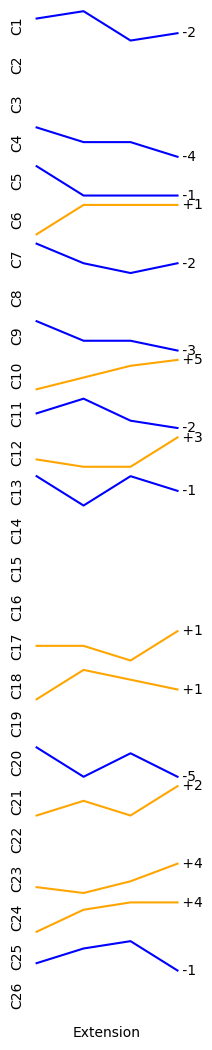

0


In [ ]:
# plot line charts 

data = noncovalent_bonds
communities_included = list(data[extensions[0]].keys())
num_communities = len(communities_included)

fig, axes = plt.subplots(num_communities, 1, figsize=(2, 0.5 * num_communities), sharex=True)
total_diff = 0

for i in range(num_communities):
    
    community = str(i+1)
    y_values = [data[ext][community] for ext in extensions]
    diff = y_values[-1] - y_values[0]
    total_diff += diff 
    
    if "C" + community not in communities_with_noncovalent_changes or diff == 0: 
        color = 'white'
    else:
        if diff > 0: color = 'orange'
        else: color = 'blue'
    
    axes[i].plot(extensions, y_values, color=color)
    axes[i].set_ylabel(f'C{community}')
    # print(i, change, color )
    
    if color != "white":
        sign = " +" if y_values[-1] > y_values[0] else " -"
        axes[i].text(extensions[-1], y_values[-1], f'{sign}{abs(diff):.0f}', va='center', ha='left', fontsize=10, color='black')
        
    # Remove grid and axis lines
    axes[i].grid(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['left'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].tick_params(left=False, bottom=False, labelleft=False)

axes[-1].set_xlabel('Extension')
axes[-1].set_xticklabels([""] * len(extensions), fontsize=8)

# fig.suptitle('Non-covalent Bonds by Community', fontsize=14)
# plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print(total_diff)

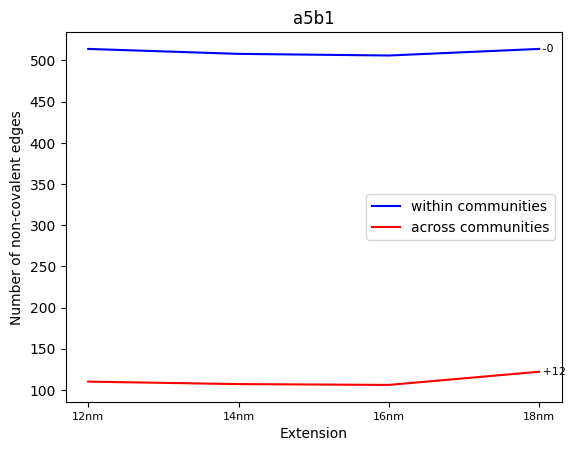

In [128]:
plt.plot(extensions, within_noncov_list, color="blue", label="within communities")
plt.plot(extensions, across_noncov_list, color="red", label="across communities")

change = across_noncov_list[-1] - across_noncov_list[0]
sign = "+" if change > 0 else "-"
plt.text(extensions[-1], across_noncov_list[-1], f' {sign}{abs(change):.0f}', va='center', ha='left', fontsize=8, color='black')

change = within_noncov_list[-1] - within_noncov_list[0]
sign = "+" if change > 0 else "-"
plt.text(extensions[-1], within_noncov_list[-1], f' {sign}{abs(change):.0f}', va='center', ha='left', fontsize=8, color='black')

plt.xlabel('Extension')
plt.ylabel("Number of non-covalent edges")# 
# plt.ylim(0, 500)
plt.xticks(range(len(extensions)), labels=extensions, fontsize=8)
plt.title(integrin)
plt.legend()
plt.show()

## Displacement and rotation

In [129]:
import seaborn as sns

In [130]:
if integrin == "aVb3": color = "lightblue"
elif integrin == "alphaVbeta3": color = "skyblue"
elif integrin == "a5b1": color = "pink"
else: color = "lightgreen"

In [131]:
# Extract displacement and rotation values
df_communities["Disp_val"] = df_communities["Disp (A)"].apply(lambda x: float(x.split()[0]))
df_communities["Rot_max"] = df_communities["RotAx"].apply(
    lambda x: max(map(lambda v: abs(float(v)), re.findall(r'-?\d+\.?\d*', x))) 
)
df_communities["Rot_avg"] = df_communities["RotAx"].apply(
    lambda x: np.mean(list(map(lambda v: abs(float(v)), re.findall(r'-?\d+\.?\d*', x))))
)


In [132]:
df_communities.reset_index(inplace=True)
for i in range(len(df_communities)):
    domain = df_communities.iloc[i]["Domain"].split("(")[0]
    label_text = f"{df_communities["index"][i]} ({domain.replace(" ","")})"
    df_communities.loc[df_communities.index[i], "label"] = label_text
# df_sorted.reset_index(inplace=True)
df_communities.set_index("label", inplace=True)

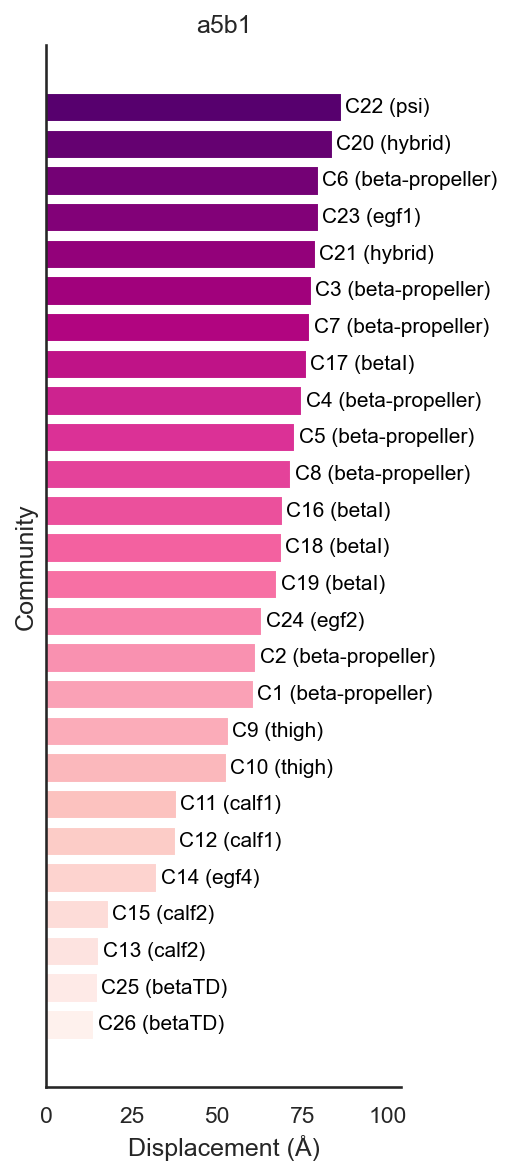

In [133]:
# bar chart
# Prepare the data
df_plot = df_communities["Disp_val"].dropna().sort_values(ascending=False)

# Set style
sns.set(style="white")

# Set figure size (tall and thin)
fig, ax = plt.subplots(figsize=(3.5, 8), dpi=150)

# Choose a nice colormap
colors = sns.color_palette("RdPu", len(df_plot))[::-1]

# Create the horizontal barplot
bars = ax.barh(df_plot.index, df_plot.values, color=colors)

# Invert y-axis so highest value is at top
ax.invert_yaxis()

# Remove y-axis ticks and labels
ax.tick_params(axis='y', left=False, labelleft=False)

# Add C-name labels at the end of bars
for i, (label, value) in enumerate(zip(df_plot.index, df_plot.values)):
    ax.text(value + 1, i, label, va='center', fontsize=10, color='black')

# Format x-axis
ax.set_xlabel("Displacement (Å)", fontsize=12)
ax.set_xlim([0, df_plot.max() * 1.2])  # Add space on the right
ax.set_ylabel("Community")
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True, left=False)

plt.title(f"{integrin}")
plt.tight_layout()
plt.show()


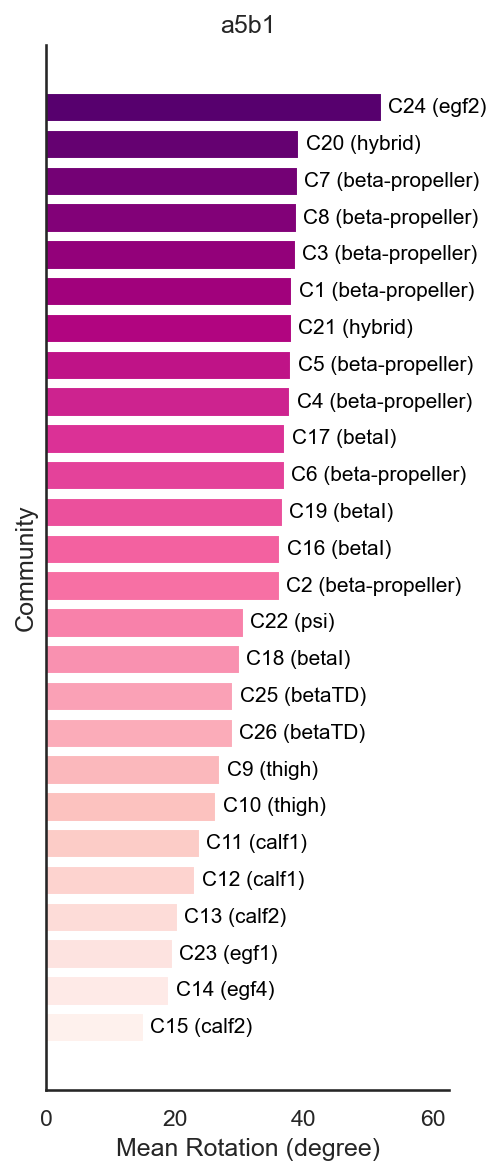

In [134]:
# bar chart
# Prepare the data
df_plot = df_communities["Rot_avg"].dropna().sort_values(ascending=False)
df_plot = df_plot[df_plot > 0]
# Set style
sns.set(style="white")

# Set figure size (tall and thin)
fig, ax = plt.subplots(figsize=(3.5, 8), dpi=150)

# Choose a nice colormap
colors = sns.color_palette("RdPu", len(df_plot))[::-1]

# Create the horizontal barplot
bars = ax.barh(df_plot.index, df_plot.values, color=colors)

# Invert y-axis so highest value is at top
ax.invert_yaxis()

# Remove y-axis ticks and labels
ax.tick_params(axis='y', left=False, labelleft=False)

# Add C-name labels at the end of bars
for i, (label, value) in enumerate(zip(df_plot.index, df_plot.values)):
    ax.text(value + 1, i, label, va='center', fontsize=10, color='black')

# Format x-axis
ax.set_xlabel("Mean Rotation (degree)", fontsize=12)
ax.set_xlim([0, df_plot.max() * 1.2])  # Add space on the right
ax.set_ylabel("Community")
# Remove top and right spines
sns.despine(ax=ax, top=True, right=True, left=False)

plt.title(f"{integrin}")
plt.tight_layout()
plt.show()


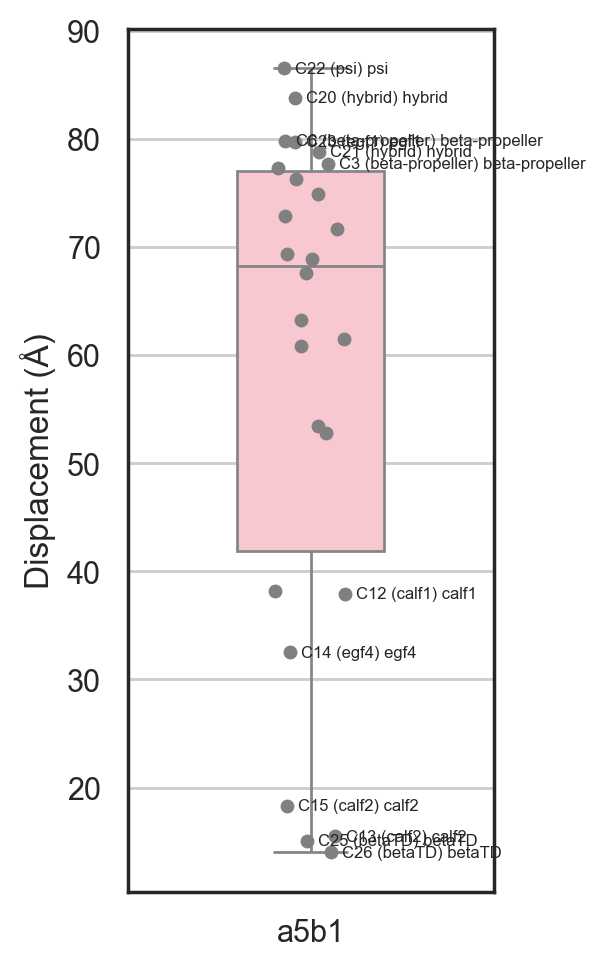

In [135]:
plt.figure(figsize=(3, 5), dpi=200)
top_k = 6
font_size = 6

ax = sns.boxplot(y=df_communities["Disp_val"], color=color, width=0.4)
strip = sns.stripplot(y=df_communities["Disp_val"], color="gray", jitter=True)

# Get jittered x and y positions from PathCollection offsets
offsets = strip.collections[0].get_offsets()
strip_coords = list(offsets)  # List of (x, y) tuples

# Add top labels
top_disp = df_communities.nlargest(top_k, 'Disp_val')
for i, (y_val, label) in enumerate(zip(top_disp["Disp_val"], top_disp.index)):
    domain = top_disp.iloc[i]["Domain"].split("(")[0]
    label_text = f"{label} {domain}"
    
    # Find closest jittered point in y, and get corresponding x
    x_val = min(strip_coords, key=lambda t: abs(t[1] - y_val))[0]
    plt.text(x_val + 0.03, y_val, label_text, fontsize=font_size, va='center')

# Add bottom labels
bottom_disp = df_communities.nsmallest(top_k, 'Disp_val')
for i, (y_val, label) in enumerate(zip(bottom_disp["Disp_val"], bottom_disp.index)):
    domain = bottom_disp.iloc[i]["Domain"].split("(")[0]
    # label_text = f"{label} {domain}"
    label_text = f"{label} {domain}"
    
    x_val = min(strip_coords, key=lambda t: abs(t[1] - y_val))[0]
    plt.text(x_val + 0.03, y_val, label_text, fontsize=font_size, va='center')

plt.ylabel("Displacement (Å)")
# plt.ylim(0, 180)
plt.xticks([0], labels=[integrin])
plt.grid(axis='y')
plt.tight_layout()
# plt.title(integrin)
plt.show()

## Bubble schematic

In [136]:
from utils.visualization import plot_oriented_ellipsoids

In [137]:
df_communities.reset_index(inplace=True)
df_communities.set_index("index", inplace=True)

In [138]:
communities_snapshot = {}
for c in communities_sorted.keys():
    communities_snapshot[c] = {}
    for t in range(len(extensions)):
        communities_snapshot[c][t] = []
    for n in list(communities_sorted[c].keys()):
        if isinstance(communities_sorted[c][n], list):
            for t in communities_sorted[c][n]:
                communities_snapshot[c][t].append(n)
            
positions = defaultdict(dict)
for t in range(len(extensions)):
    for c in list(communities_sorted.keys()):
        if len(communities_snapshot[c][t]) > 0:
            resindices = communities_snapshot[c][t]
            # residx = [residue_to_index[resindex] for resindex in resindices]
            residx = [resindices_to_index[resindex] for resindex in resindices]
            pos = u[rep][extensions[t]].select_atoms("protein and name CA").positions[residx]
            positions[t][c] = pos

    # add transmembrane
    if integrin == "alphaVbeta3":
        indices1 = u[rep][extensions[t]].select_atoms(f"protein and name CA and segid B and resid 693-900").atoms.resindices,
        indices2 = u[rep][extensions[t]].select_atoms(f"protein and name CA and segid A and resid 968-1016").atoms.resindices,
    elif integrin == "alpha2bbeta3":
        indices2 = u[rep][extensions[t]].select_atoms(f"protein and name CA and segid A and resid 966-1080").atoms.resindices,
        indices1 = u[rep][extensions[t]].select_atoms(f"protein and name CA and segid B and resid 1700-1769").atoms.resindices,
    
    if "alpha" in integrin:
        pos = u[rep][extensions[t]].select_atoms("protein and name CA").positions[indices1]
        positions[t]["transA"] = pos
        pos = u[rep][extensions[t]].select_atoms("protein and name CA").positions[indices2]
        positions[t]["transB"] = pos
        print("Time", t, "has", len(positions[t]), "communities and", count, "one-node communities")

In [139]:
    
domain_colors = []
for i in range(df_communities.shape[0]):
    chain = df_communities.iloc[i]["Chain"][0]
    if "A" in chain:
        domain_colors.append("darkred")
    elif "B" in chain:
        domain_colors.append("darkgreen")
    else:
        domain_colors.append("grey")

In [140]:
# visualize difference between CMD and SMD
t1, t2 = 0, 3

starting_positions, ending_positions = [], [] 
for c in communities_sorted.keys():
    if c in positions[t1].keys():
        starting_positions.append(positions[t1][c])
    else:
        starting_positions.append(np.zeros((0, 3)))
    if c in positions[t2].keys():
        ending_positions.append(positions[t2][c])
    else:
        ending_positions.append(np.zeros((0, 3)))
        
if "alpha" in integrin:
    starting_positions.append(positions[t1]["transA"])
    starting_positions.append(positions[t1]["transB"])
    ending_positions.append(positions[t2]["transA"])
    ending_positions.append(positions[t2]["transB"])

plot_oriented_ellipsoids(
    starting_positions,
    molecules_list2 = ending_positions,
    domain_colors = domain_colors # color by green/red based on chain 
)

## Bonds

In [147]:
atom_ids = u[rep][extensions[0]].select_atoms("protein and name CA").resids
segids = u[rep][extensions[0]].select_atoms("protein and name CA").segids

residue_indices = list(resindices_to_index.keys())

node_dict = defaultdict(lambda: defaultdict(str))
for community, nodes in communities_sorted.items():
    if community in communities_sorted.keys():
        for node, timesteps in nodes.items():
            if isinstance(timesteps, list):
                for t in timesteps:
                    node_dict[node][t] = community
                

In [150]:
t = 0
adj_matrix = dist_matrices[extensions[t]]

for c in communities_sorted.keys():
    communities_sorted[c]["covalent_bonds"] = 0
    communities_sorted[c]["noncovalent_bonds"] = 0

n_com = len(communities_sorted)
covalent_bonds = np.zeros((n_com, n_com))
noncovalent_bonds = np.zeros((n_com, n_com))

non_covalent_large_dist = 0 
for i in range(adj_matrix.shape[0]):
    for j in range(i+1, adj_matrix.shape[1]):
        try:
            node1, node2 = residue_indices[i], residue_indices[j]
            index1, index2 = resindices_to_index[node1], resindices_to_index[node2]
            c1, c2 = int(node_dict[node1][t])-1, int(node_dict[node2][t])-1
        
        except Exception as e:
            print(e)
            continue 
        if abs(atom_ids[index1]-atom_ids[index2]) == 1 and segids[index1] == segids[index2]:
            if adj_matrix[i,j]==0:
                non_covalent_large_dist += 1
            covalent_bonds[c1, c2] += 1
        elif adj_matrix[i,j]>0:
            noncovalent_bonds[c1, c2] += 1
non_covalent_large_dist

47

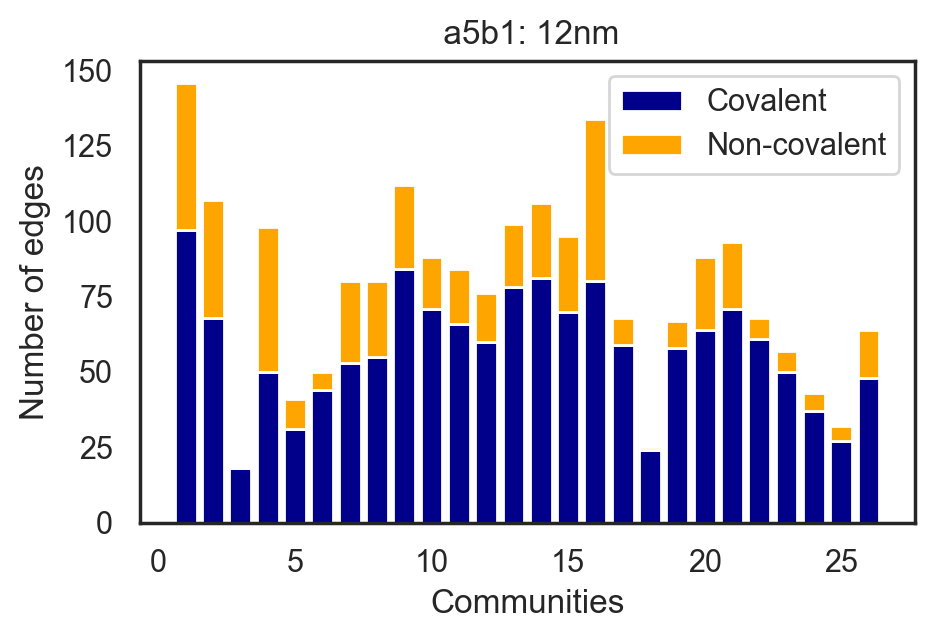

In [151]:
plt.figure(figsize=(5, 3), dpi=200)

x = np.arange(n_com) + 1

# Plot the stacked bar chart
series1 = [covalent_bonds[i,i] for i in range(n_com)]
series2 = [noncovalent_bonds[i,i] for i in range(n_com)]
plt.bar(x, series1, label='Covalent', color='darkblue')
plt.bar(x, series2, label='Non-covalent', bottom=series1, color='orange')

# Add labels, title, and legend
plt.xlabel('Communities')
plt.ylabel('Number of edges')
cov = np.sum(covalent_bonds)
noncov = np.sum(noncovalent_bonds)
# plt.title(f'{extensions}nm \n (covalent={cov:.0f}, non-covalent={noncov:.0f})')
plt.title(f' {integrin}: {extensions[t]}') # \n (covalent={cov:.0f}, non-covalent={noncov:.0f})')
plt.legend()

# Display the plot
plt.show()

## Angle between adjacent communities

In [152]:
from utils.geometry import angle_between_vectors

In [ ]:
t1, t2 = 0, 3
rep = 0
warm_up_frames = 1

In [ ]:
# compute displacement of each residue between two time points 
residue_indices = list(resindices_to_index.keys())
u_free_avg_positions = get_average_trajectory_positions(u[rep][extensions[t1]], warm_up_frames=warm_up_frames)
u_force_avg_positions = get_average_trajectory_positions(u[rep][extensions[t2]], warm_up_frames=warm_up_frames)
displacement = u_force_avg_positions - u_free_avg_positions

# compute angle between all pairwise residues 
angle_residues = np.zeros((displacement.shape[0], displacement.shape[0]))

for i in range(displacement.shape[0]):
    for j in range(i, displacement.shape[0]):
        angle_residues[i,j] = angle_residues[j,i] = angle_between_vectors(displacement[i], displacement[j])

# average angle between all residues in the same community 
n_com = len(communities_sorted)
angles = np.zeros((n_com, n_com))
counts = np.zeros((n_com, n_com))

for i in range(displacement.shape[0]):
    for j in range(displacement.shape[0]):

        node1, node2 = residue_indices[i], residue_indices[j]
        index1, index2 = resindices_to_index[node1], resindices_to_index[node2]
        c1, c2 = int(node_dict[node1][t])-1, int(node_dict[node2][t])-1
        
        angles[c1, c2] += angle_residues[i,j]
        counts[c1, c2] += 1

avg_angles = np.divide(angles, counts)

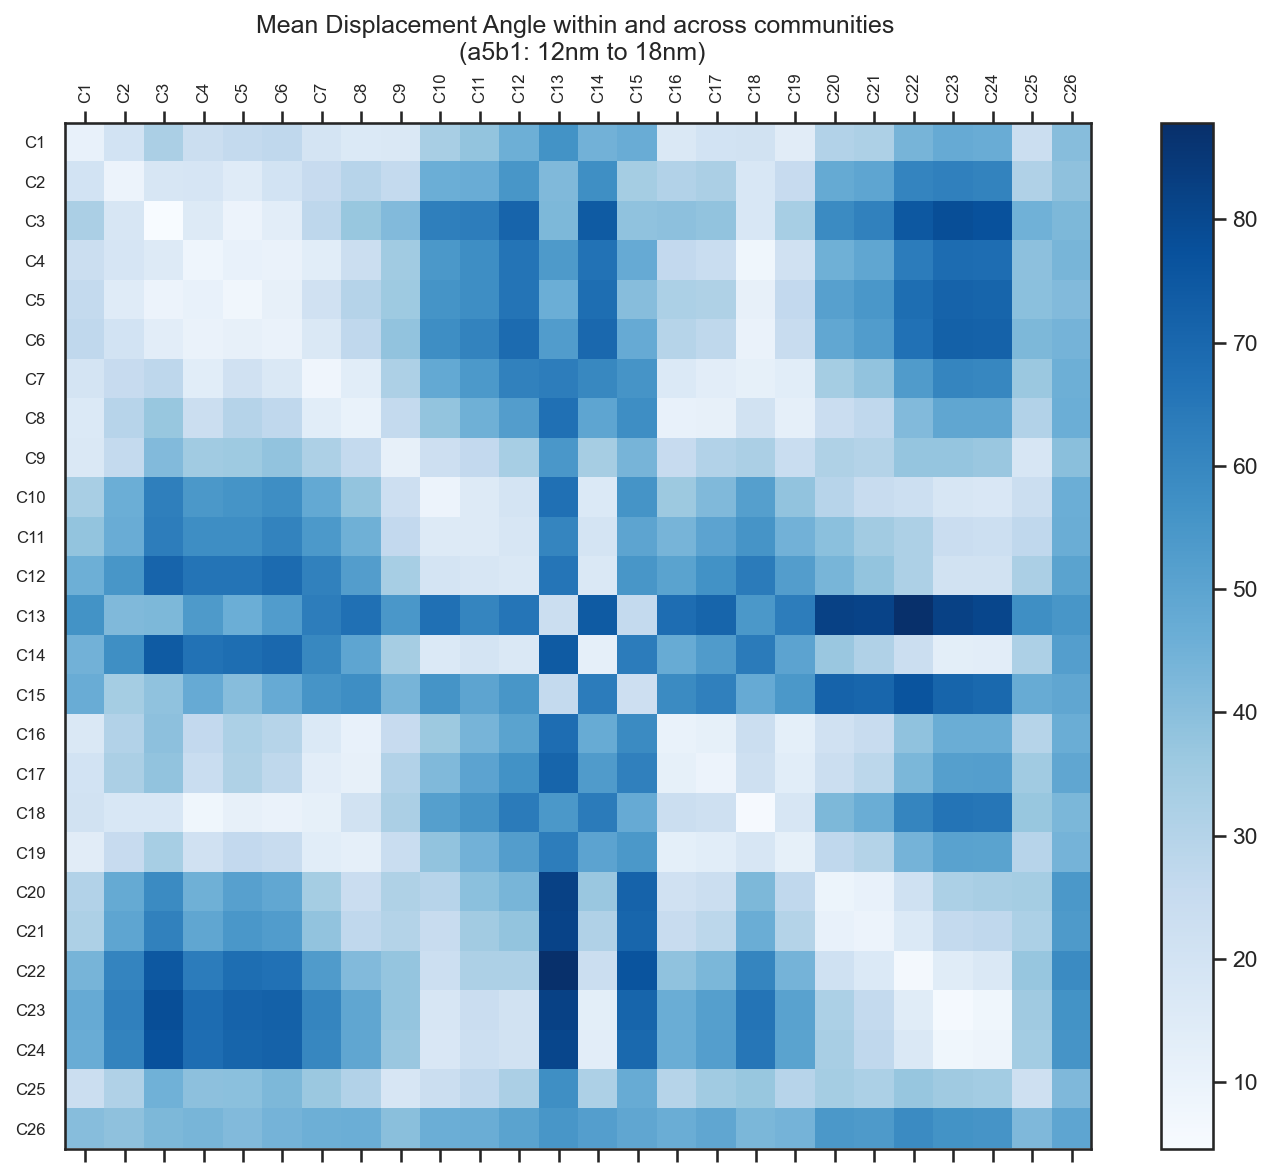

In [179]:
# Plot the heatmap
fig, ax = plt.subplots(figsize=(10, 8), dpi=150)  # Adjust figure size for better readability
cax = ax.matshow(avg_angles, cmap='Blues')  # Use 'viridis' colormap

# Add colorbar
plt.colorbar(cax)
ax.set_xticks(range(avg_angles.shape[1]))
ax.set_yticks(range(avg_angles.shape[0]))
ax.set_xticklabels([f'C{i}' for i in range(1, n_com+1)], fontsize=8, rotation=90)  # Rotate labels for clarity
ax.set_yticklabels([f'C{i}' for i in range(1, n_com+1)], fontsize=8)
plt.title(f"Mean Displacement Angle within and across communities \n ({integrin}: {extensions[t1]} to {extensions[t2]})")
plt.tight_layout()
plt.show()

In [183]:
# print angles within communities 
for i in range(n_com):
    print(f"C{i} Δangle={avg_angles[i,i]:.1f}°")

C0 Δangle=10.9°
C1 Δangle=9.2°
C2 Δangle=4.6°
C3 Δangle=8.4°
C4 Δangle=7.5°
C5 Δangle=10.0°
C6 Δangle=7.9°
C7 Δangle=10.4°
C8 Δangle=11.4°
C9 Δangle=9.4°
C10 Δangle=15.4°
C11 Δangle=16.4°
C12 Δangle=22.9°
C13 Δangle=11.8°
C14 Δangle=22.5°
C15 Δangle=10.1°
C16 Δangle=9.3°
C17 Δangle=5.3°
C18 Δangle=11.5°
C19 Δangle=9.0°
C20 Δangle=9.2°
C21 Δangle=6.3°
C22 Δangle=5.8°
C23 Δangle=8.6°
C24 Δangle=21.9°
C25 Δangle=49.2°


## Connectivity Matrix

In [ ]:
t = 3

adj_matrix = dist_matrices[extensions[t]]
residue_to_index = {}
for k, v in index_to_residue.items():
    residue_to_index[v] = k

In [184]:
n_com = len(communities_sorted.keys()) 
num_links = np.zeros((n_com , n_com ))
num_link_noncovalent = np.zeros((n_com, n_com))

for i in range(adj_matrix.shape[0]):
    for j in range(i+1, adj_matrix.shape[1]):
        # if abs(i-j) != 1:
        try:
            node1, node2 = residue_indices[i], residue_indices[j]
            index1, index2 = resindices_to_index[node1], resindices_to_index[node2]
            id1, id2 = atom_ids[index1], atom_ids[index2]
            c1, c2 = int(node_dict[node1][t])-1, int(node_dict[node2][t])-1
            
            if adj_matrix[i,j]>0:
                if c1 == c2:
                    num_links[c1, c2] += 1
                else:
                    num_links[c1, c2] += 1
                    num_links[c2, c1] += 1
                
                if abs(id1-id2) == 1:
                    if c1 == c2:
                        num_link_noncovalent[c1, c2] += 1
                    else:
                        num_link_noncovalent[c1, c2] += 1
                        num_link_noncovalent[c2, c1] += 1
                    
        except Exception as e:
            pass 

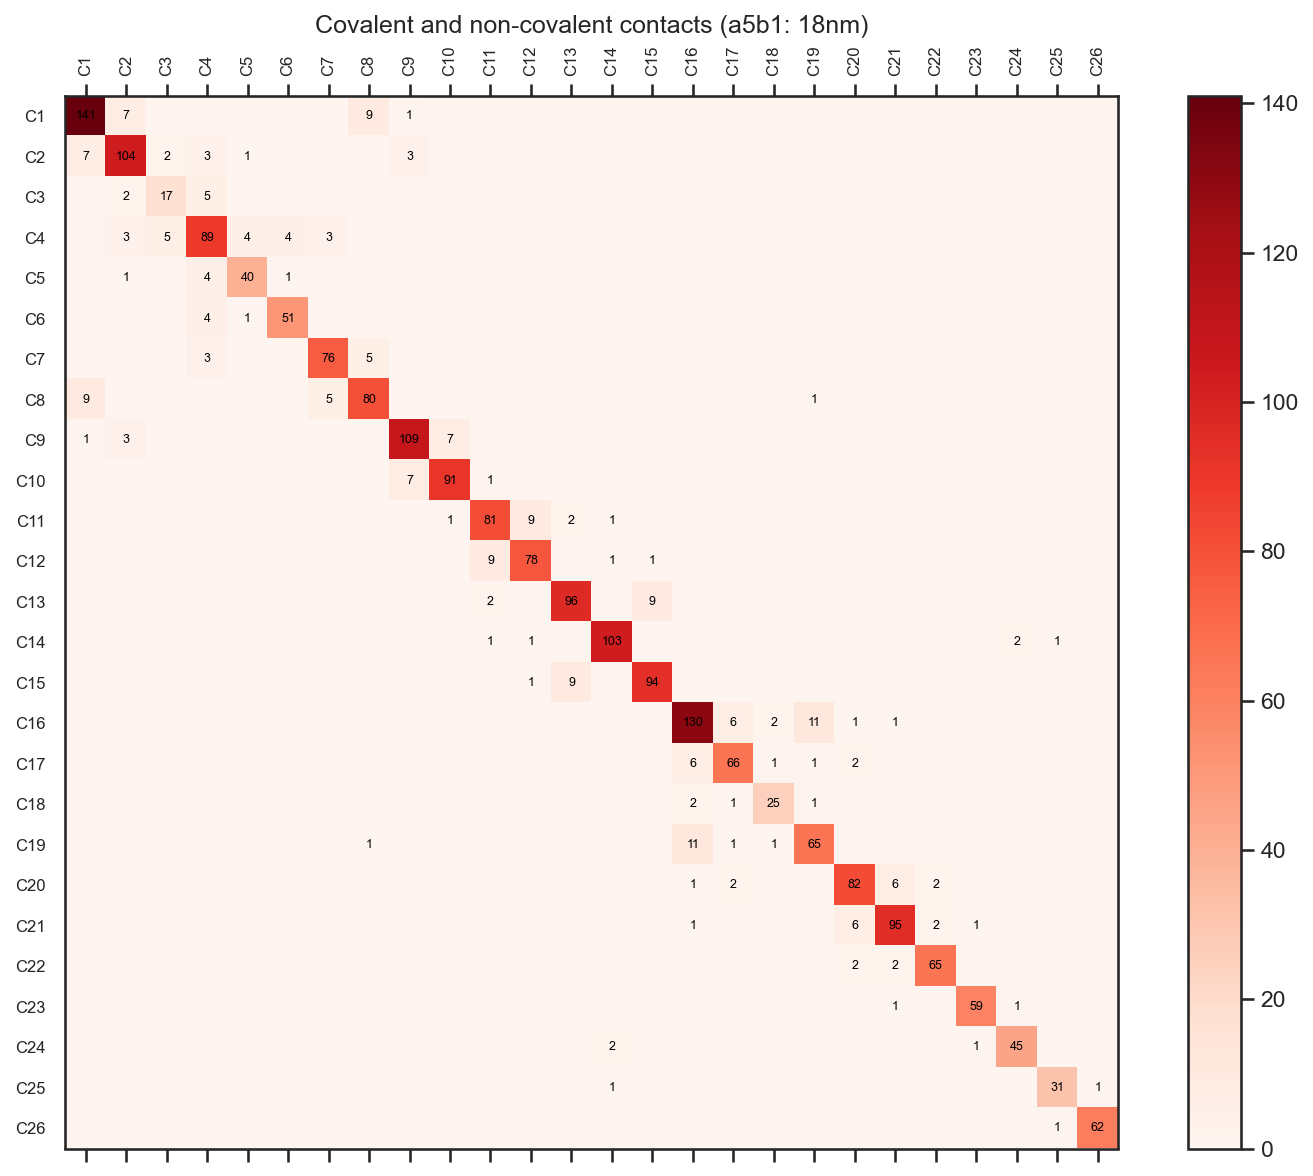

In [187]:
# Plot the heatmap for covalent and non-covalent contacts
fig, ax = plt.subplots(figsize=(10, 8), dpi=150)  # Adjust figure size for better readability
cax = ax.matshow(num_links, cmap='Reds')  # Use 'viridis' colormap
plt.colorbar(cax)
for (i, j), val in np.ndenumerate(num_links):
    if val != 0:
        ax.text(j, i, f'{val:.0f}', ha='center', va='center', fontsize=6, color='black')
ax.set_xticks(range(num_links.shape[1]))
ax.set_yticks(range(num_links.shape[0]))
ax.set_xticklabels([f'C{i}' for i in range(1, n_com+1)], fontsize=8, rotation=90)  # Rotate labels for clarity
ax.set_yticklabels([f'C{i}' for i in range(1, n_com+1)], fontsize=8)
plt.title(f"Covalent and non-covalent contacts ({integrin}: {extensions[t]})", fontsize=12)
plt.tight_layout()
plt.show()


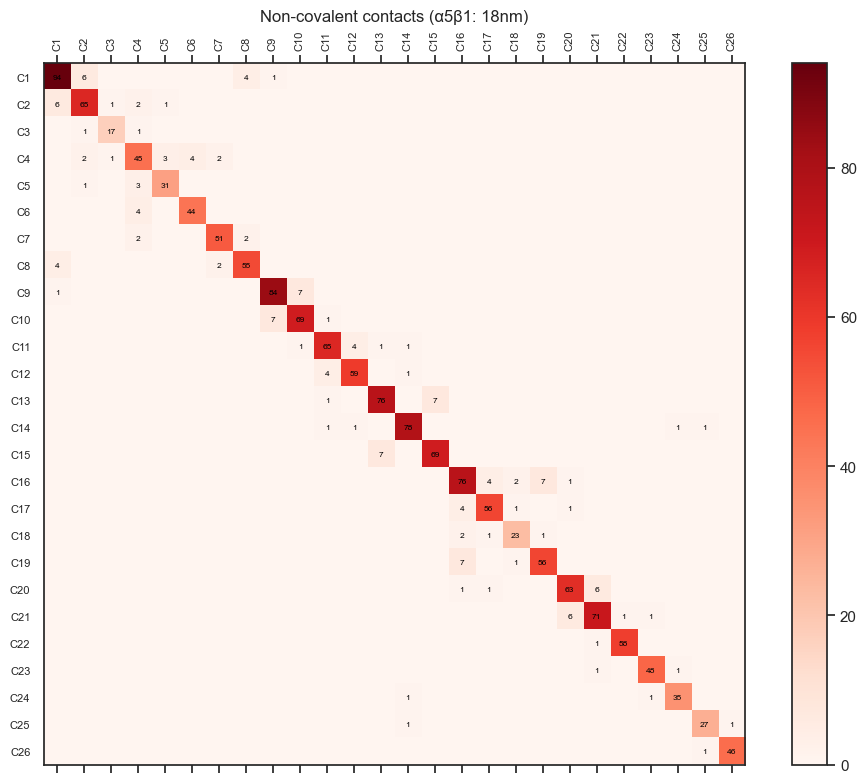

In [ ]:
# Plot the heatmap for non-covalent contacts
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size for better readability
cax = ax.matshow(num_link_noncovalent, cmap='Reds')  # Use 'viridis' colormap
plt.colorbar(cax)
for (i, j), val in np.ndenumerate(num_link_noncovalent):
    if val > 0:
        ax.text(j, i, f'{val:.0f}', ha='center', va='center', fontsize=6, color='black')
ax.set_xticks(range(num_link_noncovalent.shape[1]))
ax.set_yticks(range(num_link_noncovalent.shape[0]))
ax.set_xticklabels([f'C{i}' for i in range(1, n_com+1)], fontsize=8, rotation=90)  # Rotate labels for clarity
ax.set_yticklabels([f'C{i}' for i in range(1, n_com+1)], fontsize=8)
plt.title(f"Non-covalent contacts ({integrin}: {extensions[t]})", fontsize=12)
plt.tight_layout()
plt.show()


In [188]:
del num_links, num_link_noncovalent

## Community Stability: NMI and ARI

In [189]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

In [193]:
node_dict = defaultdict(lambda: defaultdict(str))
for community, nodes in communities_sorted.items():
    if community in communities_sorted.keys():
        for node, timesteps in nodes.items():
            if isinstance(timesteps, list):
                for t in timesteps:
                    node_dict[node][t] = community

In [196]:
t1, t2 = 0, 1

node_dict1, node_dict2 = [], []
for n in node_dict.keys():
    node_dict1.append(node_dict[n][t1])
    node_dict2.append(node_dict[n][t2])
    
ari = adjusted_rand_score(node_dict1, node_dict2)
nmi = normalized_mutual_info_score(node_dict1, node_dict2, average_method='arithmetic')
print("Adjusted Rand Index (ARI):", ari)
print("Normalized Mutual Information (NMI):", nmi)


Adjusted Rand Index (ARI): 1.0
Normalized Mutual Information (NMI): 1.0


# Interface Analysis

In [197]:
from utils.geometry import angle_between_vectors

In [198]:
t1, t2 = 0, 3
u_free_avg_positions = get_average_trajectory_positions(u[rep][extensions[t1]], warm_up_frames=warm_up_frames)
u_force_avg_positions = get_average_trajectory_positions(u[rep][extensions[t2]], warm_up_frames=warm_up_frames)
u_free_avg_positions.shape, u_force_avg_positions.shape

There are 1595 residues and 201 timestamps


100%|██████████| 200/200 [00:00<00:00, 1638.19it/s]


There are 1595 residues and 101 timestamps


100%|██████████| 100/100 [00:00<00:00, 1748.23it/s]


((1595, 3), (1595, 3))

In [205]:
node_dict = defaultdict(lambda: defaultdict(str))
for community, nodes in communities_sorted.items():
    for node, timesteps in nodes.items():
        if isinstance(timesteps, list):
            for t in timesteps:
                node_dict[node][t] = community
                
communities_snapshot = {}
for c in communities_sorted.keys():
    communities_snapshot[c] = {}
    for t in range(len(extensions)):
        communities_snapshot[c][t] = []
    for n in list(communities_sorted[c].keys()):
        if isinstance(n, str):
            continue 
        for t in communities_sorted[c][n]:
            communities_snapshot[c][t].append(n)
            
len(communities_snapshot.keys())

26

In [206]:
displacement = u_force_avg_positions - u_free_avg_positions
pairwise_displacement = np.zeros((displacement.shape[0], displacement.shape[0]))
for i in range(displacement.shape[0]):
    for j in range(i, displacement.shape[0]):
        angle = angle_between_vectors(displacement[i], displacement[j])
        pairwise_displacement[i,j] = pairwise_displacement[j,i] = angle 
        # print(f"Angle (degrees): {angle}")

In [ ]:
df_interface = pd.DataFrame()
df_interface.index.name = "community pair"
communities_included = list(communities_sorted.keys())

t = 0
interface_residues_dict = {}

for i in range(len(communities_included)):
    for j in range(i+1, len(communities_included)):
        c1, c2 = communities_included[i], communities_included[j]
        
        interface_residues_dict["C" + c1 + "-" + "C" + c2] = {}
        nodes_c1 = communities_snapshot[c1][t]
        nodes_c2 = communities_snapshot[c2][t]
        idx_c1 = [resindices_to_index[n] for n in nodes_c1]
        idx_c2 = [resindices_to_index[n] for n in nodes_c2]
        mask = np.zeros_like(dist_matrices[extensions[t]])
        mask[np.ix_(idx_c1, idx_c2)] = dist_matrices[extensions[t]][np.ix_(idx_c1, idx_c2)]
        
        interface_idx = np.where(mask > 0)
        
        interface_c1 = [k for k in interface_idx[0]]
        interface_c1 = sorted(list(set(interface_c1)))
        interface_c2 = [k for k in interface_idx[1]]
        interface_c2 = sorted(list(set(interface_c2)))

        interface_bounded, interface_unbounded = [], []
        for k in range(interface_idx[0].shape[0]):
            i1, i2 = interface_idx[0][k], interface_idx[1][k]
            resid1 = u[rep][extensions[t]].select_atoms("protein and name CA")[i1].resname + str(u[rep][extensions[t]].select_atoms("protein and name CA")[i1].resid)
            resid2 = u[rep][extensions[t]].select_atoms("protein and name CA")[i2].resname + str(u[rep][extensions[t]].select_atoms("protein and name CA")[i2].resid)
            if abs(interface_idx[0][k] - interface_idx[1][k]) == 1:
                interface_bounded.append(resid1 + "-" + resid2)
            else:
                interface_unbounded.append(resid1 + "-" + resid2)

        df_interface.loc["C" + c1 + "-" + "C" + c2, "Number of interface residues"] = len(interface_c1) + len(interface_c2)
        df_interface.loc["C" + c1 + "-" + "C" + c2, "Adjacent pairs"] = str.join(", ", interface_bounded) + " "
        df_interface.loc["C" + c1 + "-" + "C" + c2, "Non-adjacent pairs"] = str.join(", ", interface_unbounded)+ " "
        
        df_interface.loc["C" + c1 + "-" + "C" + c2, "Disp angle within C1"] = np.round(np.mean(pairwise_displacement[idx_c1, :][:, idx_c1]),1)
        df_interface.loc["C" + c1 + "-" + "C" + c2, "Disp angle within C2"] = np.round(np.mean(pairwise_displacement[idx_c2, :][:, idx_c2]),1)
        df_interface.loc["C" + c1 + "-" + "C" + c2, "Disp angle between C1 and C2"] = np.round(np.mean(pairwise_displacement[idx_c1, :][:, idx_c2]),1)

In [208]:
df_interface = df_interface[df_interface["Number of interface residues"] > 0]
df_interface

,Number of interface residues,Adjacent pairs,Non-adjacent pairs,Disp angle within C1,Disp angle within C2,Disp angle between C1 and C2
community pair,,,,,,
C1-C2,12.0,"VAL10-LEU11, PRO412-ASP413, VAL435-GLY436, SER...",LEU425-PRO28,10.9,9.2,20.0
C1-C8,11.0,"VAL294-ASP293, GLY296-ASP297, GLY349-ARG350, P...","GLY349-VAL321, GLY352-GLY305, GLY352-VAL324",10.9,10.4,16.2
C1-C9,2.0,GLY448-ARG449,,10.9,11.4,16.7
C2-C3,5.0,GLU71-PHE72,"GLN46-SER74, GLN46-LYS75",9.2,4.6,17.7
C2-C4,6.0,"SER97-LYS96, LEU98-GLN99",PHE101-ALA116,9.2,8.4,18.5
C2-C5,7.0,GLY102-ALA103,"TYR26-SER110, ARG27-GLY109, ARG27-SER110, GLY3...",9.2,7.5,14.4
C3-C4,6.0,GLU90-GLU91,"LEU79-PRO92, SER83-GLU124",4.6,8.4,15.5
C4-C5,7.0,"CYS115-ALA114, GLY133-THR134, PHE155-ASP154",CYS115-CYS135,8.4,7.5,11.0
C4-C6,8.0,"PHE168-SER169, GLY181-LEU180, ILE192-LEU193, A...",,8.4,10.0,9.9


In [209]:
df_interface.to_csv(f"results/{model_type}/{integrin}_{data_type}/interface_{extensions[t1]}_{extensions[t2]}.csv")